## Problem statement

#I decided to treat this as a classification problem by creating a new binary
variable affair (did the woman have at least one affair?) and trying to
predict the classification for each woman.

#Dataset

#The dataset I chose is the affairs dataset that comes with Statsmodels. It
was derived from a survey of women in 1974 by Redbook magazine, in
which married women were asked about their participation in extramarital
affairs. More information about the study is available in a 1978 paper from
the Journal of Political Economy.

### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Data Preprocessing

In [5]:
#Let's load the data and add a binry affair column
df = sm.datasets.fair.load_pandas().data
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [10]:
# add "affair" column: 1 represents having affairs, 0 represents not
df['affairs'] = (df.affairs>0).astype(int)
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [9]:
# Records identified where there's no affair
df.loc[df.affairs<=0].head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
2053,4.0,32.0,9.0,2.0,3.0,14.0,2.0,4.0,0.0
2054,4.0,27.0,6.0,0.0,2.0,14.0,3.0,4.0,0.0
2055,4.0,22.0,2.5,0.0,2.0,14.0,3.0,2.0,0.0
2056,5.0,42.0,23.0,4.0,3.0,16.0,3.0,5.0,0.0
2057,5.0,27.0,2.5,1.0,3.0,20.0,2.0,2.0,0.0


### Exploratory Data Analysis

In [12]:
# average oll featues grouped by affair
df.groupby('affairs').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb
affairs,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559


We can see that on average, women sho have affairs rate their marriages lower, which is to be expected. 
Let's take anothe look at the rate_marriage variable.

In [13]:
df.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
rate_marriage,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.181446


An increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

### Data Visualization

Text(0, 0.5, 'Frequency')

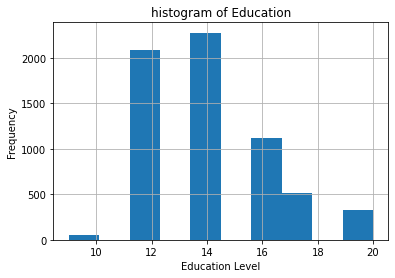

In [14]:
# Histogram of Education
df.educ.hist()
plt.title("histogram of Education")
plt.xlabel('Education Level')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

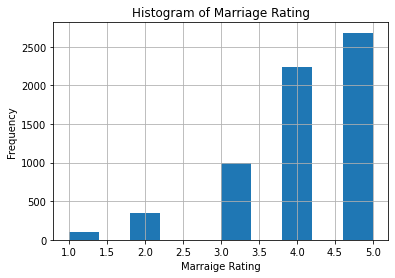

In [15]:
# Histogram of Marriage Rating
df.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marraige Rating')
plt.ylabel('Frequency')

let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.

Text(0, 0.5, 'Frequency')

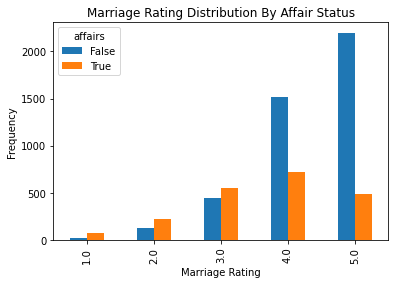

In [17]:
# Barplot of marriage rating groupedby by affair(Tru or False)
pd.crosstab(df.rate_marriage, df.affairs.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution By Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's use a stacked bar plot to look at the percentage of women haivng affairs by number of years of marriage.

Text(0, 0.5, 'Percentage')

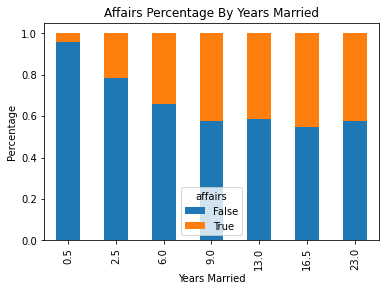

In [19]:
affair_yrs_married = pd.crosstab(df.yrs_married, df.affairs.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affairs Percentage By Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

### Prepare Data for Logistic Regresson
To prepare the data i want to add an intercept column as well as dummy variables for occupation and occupation_husb, and i'm treating them as categorical variables. The dmatrices from the patsy module can do that using formula language.

In [21]:
#Create a dataframe woth an intercept column and dummy variables for occupation and occupational_husb
y, X = dmatrices('affairs ~ rate_marriage + age + yrs_married + children + \
                religious + educ + C(occupation)+ C(occupation_husb)',
               df, return_type="dataframe")
X.columns


Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')

The column names for the dummy variables are ugly, so let's rename those

In [22]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.

In [23]:
# flatten y into 1-D array

y= np.ravel(y)

In [24]:
X.columns

Index(['Intercept', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
       'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage',
       'age', 'yrs_married', 'children', 'religious', 'educ'],
      dtype='object')

### Logistic Regression 
Let's go and run the logistic Regression on the dataset and see how accurate it is!

In [25]:
# instantiate a logistic Regression model, and fit with X and y 
model = LogisticRegression()
modele = model.fit(X,y)

# Test the accuray on the traininf set
model.score(X,y)

C:\Users\Neelakanta S Shiroor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7251021049324536

In [26]:
# What percentage had affairs
y.mean()

0.3224945020420987

only 32% of womens had  affairs, which means that it could obtain 68% of accuracy by always predicting
'no'. So we are doing better than the null error  ratr, but not by much

Let's examine the cofficients to see what we learn

In [27]:
# Examine the coefficiecnts
X.columns, np.transpose(model.coef_)

(Index(['Intercept', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
        'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage',
        'age', 'yrs_married', 'children', 'religious', 'educ'],
       dtype='object'),
 array([[ 1.38349366],
        [ 0.06111362],
        [ 0.38297488],
        [ 0.12135087],
        [ 0.77403867],
        [ 0.23691876],
        [ 0.30252067],
        [ 0.44068012],
        [ 0.25547145],
        [ 0.27161954],
        [ 0.23977286],
        [-0.68186908],
        [-0.05878133],
        [ 0.10721324],
        [ 0.01492226],
        [-0.37356709],
        [ 0.013424  ]]))

Increase in marriage rate and religiousness corresponds to decrease in the likelihood of having an affair. For both wife's occupation and husbands occupation, the lowest likelihood of having an affair
corresponds to the baseline occupation(students), since all of the dummy coefficients are positive.

### Model Evaluation Using a Validation Set
So for, we have trained and tested on the same set, Let's instead split the data into a training set and testing set.

In [32]:
#Evaluate the model by splitting into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train,y_train)

C:\Users\Neelakanta S Shiroor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We now need to predict the class label for the test data. We will also generate the class probabilities, just to a look.

In [34]:
#  Predict class label for the test set
Predicted = model2.predict(X_test)
Predicted 

array([1., 0., 0., ..., 0., 0., 0.])

In [36]:
# Generate class probabilities 
probs = model2.predict_proba(X_test)
probs

array([[0.34434675, 0.65565325],
       [0.90319186, 0.09680814],
       [0.7208837 , 0.2791163 ],
       ...,
       [0.54206153, 0.45793847],
       [0.82162868, 0.17837132],
       [0.73725615, 0.26274385]])

As you can see a classifier is predicting a 1 (having a affair) any time the probability in the second column is greater than 0.5.
Now let's generates some evaluation metrics.

In [38]:
print(metrics.confusion_matrix(y_test, Predicted))
print(metrics.classification_report(y_test,Predicted))

[[1169  134]
 [ 383  224]]
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      1303
         1.0       0.63      0.37      0.46       607

    accuracy                           0.73      1910
   macro avg       0.69      0.63      0.64      1910
weighted avg       0.71      0.73      0.71      1910



### Model Evaluation using Cross Validation
Now let's try 10 fold cross validation, to see the accuracy holds up more rigorously.

In [39]:
 #Evaluate the model using 10 fold cross validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy',cv=10)
scores, scores.mean()

C:\Users\Neelakanta S Shiroor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Neelakanta S Shiroor\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

(array([0.72370487, 0.69858713, 0.73940345, 0.70800628, 0.71428571,
        0.72684458, 0.72798742, 0.70754717, 0.75      , 0.75314465]),
 0.7249511270400758)

Looks good, it's still predicted 73% accuracy.

### Predicting the Probability of an Affair
Just for fun, let's  predicte the probability of an affairfor random women not present in the dataset. She is a 25 year's old teacher who graduated from college, has been married for 3 years. She has 1 child, rate herself as stronghly religious, rates her marriage as fair, and her husband is famer.

In [40]:
model.predict_proba(np.array([[1,0,0,1,0,0,1,0,0,0,0,3,25,3,1,4,16]]))

array([[0.77586125, 0.22413875]])

The predicted probability of an affair is 23%